# IMPORTS

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score



## LEITURA DOS DADOS

In [2]:
df = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_CN-MCI_1_After_Pre_Processamento.csv') 
df_test = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_Test_1_After_Pre_Processamento.csv')


label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}



# Tratamento

### Normalizar Dados

In [3]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)




### Correlação com o Target

In [4]:
def remove_low_correlated_with_target(data, target_column, threshold):
    # Compute the correlation of each column with the target column
    corr_with_target = data.corr()[target_column].abs()
    
    # Identify columns to remove based on correlation with the target
    to_drop = corr_with_target[corr_with_target <= threshold].index
    
    # Remove target column itself if included in the drop list
    if target_column in to_drop:
        to_drop = to_drop.drop(target_column)
    
    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final, to_drop

# Exemplo de uso da função
print("Antes de remover:")
print(df.shape)

# Remover colunas com baixa correlação com o target
df, to_drop4 = remove_low_correlated_with_target(df, 'Transition', threshold=0.12)

# Remover as mesmas colunas no conjunto de teste (df_test)
if 'df_test' in locals():
    df_test = df_test.drop(columns=to_drop4)

print("Depois de remover:")
print(df.shape)
if 'df_test' in locals():
    print(df_test.shape)

# Normalização e remoção de colunas no dataset normalizado
print("Normalizados:")
print(df_normalizado.shape)
df_normalizado, to_drop4 = remove_low_correlated_with_target(df_normalizado, 'Transition', threshold=0.15)
print(df_normalizado.shape)


Antes de remover:
(305, 2014)
Depois de remover:
(305, 565)
(100, 564)
Normalizados:
(305, 2014)
(305, 270)


### Correlação Entre Colunas 

In [5]:
def remove_highly_correlated_features(data, threshold):
    # Compute the correlation matrix
    corr_matrix = data.corr().abs()

    # Identify columns to remove based on correlation
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                to_drop.add(corr_matrix.columns[j])

    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final, to_drop



print(df.shape)
#df, to_drop5 = remove_highly_correlated_features(df,0.95)
#df_test =  df_test.drop(columns=to_drop5)

print(df.shape)
print(df_test.shape)


(305, 565)
(305, 565)
(100, 564)


### Desvio Padrão

In [6]:


def remove_low_variance_features(data, threshold=0.01):
    # Remove low variance features
    selector = VarianceThreshold(threshold=threshold)
    low_variance_data = selector.fit_transform(data.select_dtypes(include=['float64', 'int64']))

    # Get the columns to keep
    retained_columns = data.select_dtypes(include=['float64', 'int64']).columns[selector.get_support(indices=True)]

    # Create a DataFrame with the retained columns
    data_reduced = pd.DataFrame(low_variance_data, columns=retained_columns)

    return data_reduced
print(df.shape)
#df = remove_low_variance_features(df)
print(df.shape)


(305, 565)
(305, 565)


In [7]:
# *!  df.to_csv('DF_1_After_Pre_Processamento.csv', index=False)
# *! ## df_test.to_csv('DF_Test_1_After_Pre_Processamento.csv', index=False)


# MODELOS

In [8]:
# Separar as features e o target
X = df.drop('Transition', axis=1)
y = df['Transition']


# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)


# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}
model_f1_macro = {}


### Funcao Axuliar: Matrix de Confusão

In [9]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

## Random Forest Classifier

### Score

/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

              precision    recall  f1-score   support

           0       0.59      0.71      0.64        24
           1       0.47      0.47      0.47        15
           2       0.19      0.24      0.21        17
           3       0.17      0.11      0.13        18
           4       0.00      0.00      0.00         3

    accuracy                           0.39        77
   macro avg       0.28      0.30      0.29        77
weighted avg       0.35      0.39      0.37        77



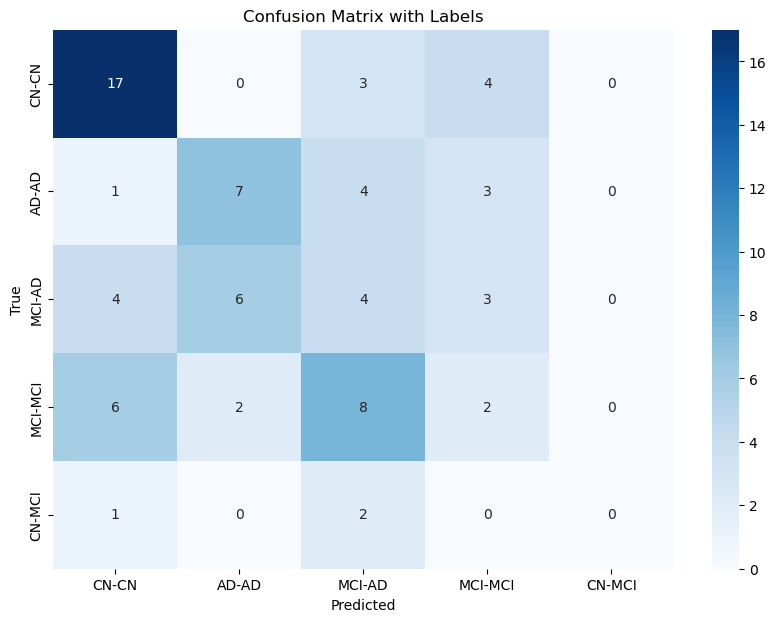

In [10]:
rf_model_score = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)


rf_model_score.fit(X_train, y_train)
rf_pred = rf_model_score.predict(X_test)
rf_f1_macro = f1_score(y_test, rf_pred, average='macro')
model_f1_macro['random_forest'] = rf_f1_macro
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)

### Cross Validation Score 

In [11]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)

rf_score = cross_val_score(rf_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

model_cross_score['random_forest'] = rf_score


## Extra Trees Classifier

### Score

              precision    recall  f1-score   support

           0       0.50      0.67      0.57        24
           1       0.45      0.33      0.38        15
           2       0.17      0.24      0.20        17
           3       0.10      0.06      0.07        18
           4       0.00      0.00      0.00         3

    accuracy                           0.34        77
   macro avg       0.24      0.26      0.24        77
weighted avg       0.30      0.34      0.31        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

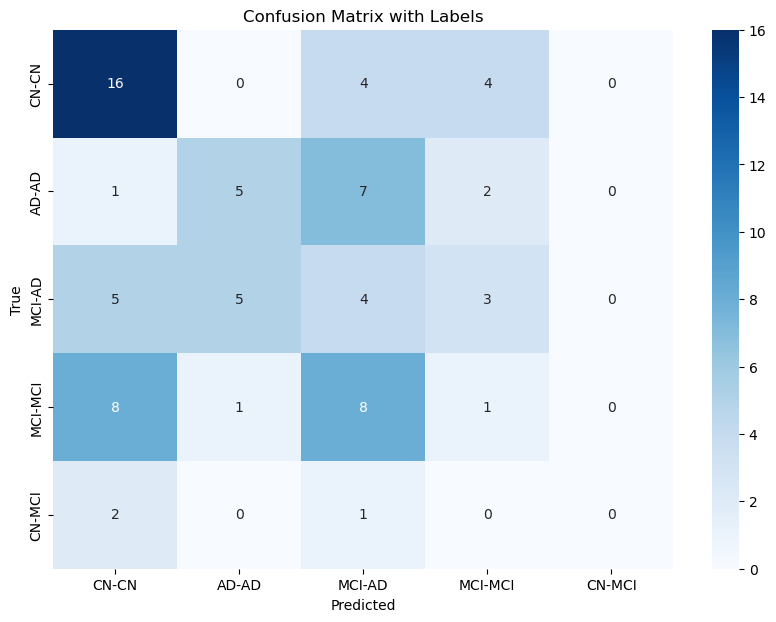

In [12]:
et_model_score = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)


et_model_score.fit(X_train, y_train)
et_pred = et_model_score.predict(X_test)
et_f1_macro = f1_score(y_test, et_pred, average='macro')
model_f1_macro['extra_trees'] = et_f1_macro

print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)



### Cross Validation Score

In [13]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

print(model_cross_score['Extra Trees'])

0.33883279665100907


## Gradient Boosting Classifier 

### Score

              precision    recall  f1-score   support

           0       0.47      0.58      0.52        24
           1       0.64      0.47      0.54        15
           2       0.26      0.29      0.28        17
           3       0.19      0.17      0.18        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.31      0.30      0.30        77
weighted avg       0.37      0.38      0.37        77



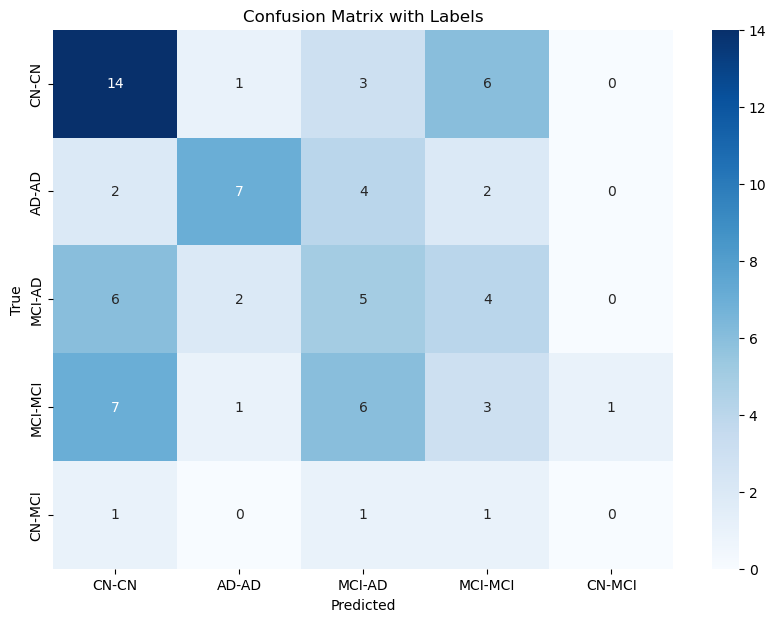

In [14]:
gb_model_score = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)


gb_model_score.fit(X_train, y_train)
gb_pred = gb_model_score.predict(X_test)
gb_f1_macro = f1_score(y_test, gb_pred, average='macro')
model_f1_macro['Gradient Boosting'] = gb_f1_macro


print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [15]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)

score_cross = cross_val_score(gb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross



0.3677629509750274


#### K Neighbors Classifier

### Score

              precision    recall  f1-score   support

           0       0.46      0.71      0.56        24
           1       0.60      0.60      0.60        15
           2       0.58      0.41      0.48        17
           3       0.46      0.33      0.39        18
           4       0.00      0.00      0.00         3

    accuracy                           0.51        77
   macro avg       0.42      0.41      0.41        77
weighted avg       0.50      0.51      0.49        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

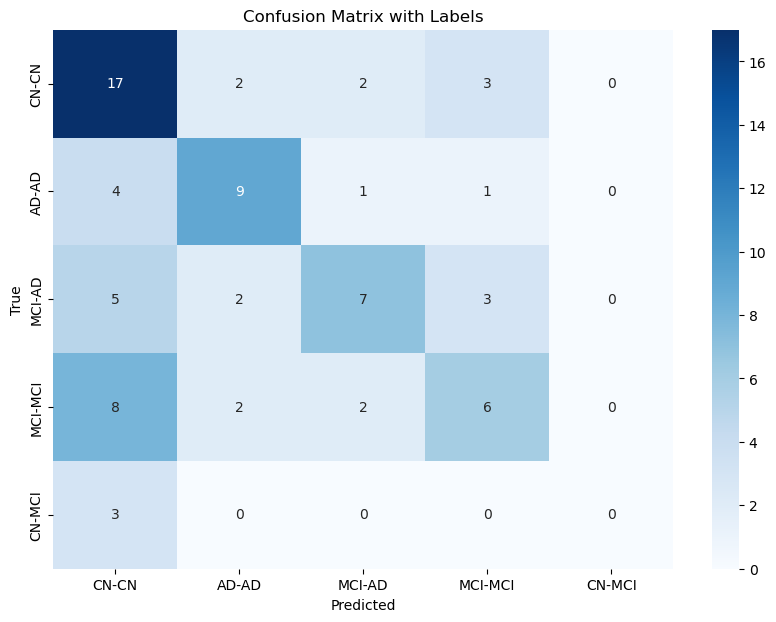

In [16]:
kn_model_score = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')


kn_model_score.fit(X_train, y_train)
kn_pred = kn_model_score.predict(X_test)
kn_f1_macro = f1_score(y_test, kn_pred, average='macro')
model_f1_macro['K neightbors'] = kn_f1_macro


print(classification_report(y_test,kn_pred))
cm = confusion_matrix(y_test,kn_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)


### Cross Validation Score

In [17]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

k_night_croos_score = cross_val_score(kn_model, X_train, y_train, cv=10,scoring='f1_macro')

print("Acuracy k night", k_night_croos_score.mean())

model_cross_score['k_night'] = k_night_croos_score.mean()


/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Acuracy k night 0.2939161394161394


#### Extreme Gradient Boosting

### Score

              precision    recall  f1-score   support

           0       0.50      0.62      0.56        24
           1       0.47      0.53      0.50        15
           2       0.24      0.24      0.24        17
           3       0.15      0.11      0.13        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.27      0.30      0.28        77
weighted avg       0.34      0.38      0.35        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

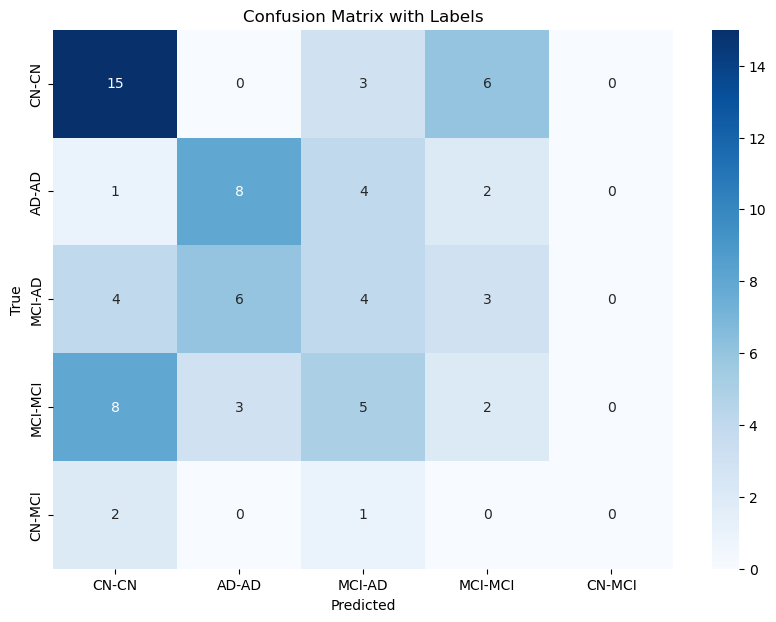

In [18]:
xgb_model_score = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)



xgb_model_score.fit(X_train, y_train)
xgb_pred = xgb_model_score.predict(X_test)
xgb_f1_macro = f1_score(y_test, xgb_pred, average='macro')
model_f1_macro['xgBoost'] = xgb_f1_macro

print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [19]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['XGBoost'] = score_cross



0.3388872291981902


## SVC

### Score

              precision    recall  f1-score   support

           0       0.50      0.62      0.56        24
           1       0.47      0.53      0.50        15
           2       0.24      0.24      0.24        17
           3       0.15      0.11      0.13        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.27      0.30      0.28        77
weighted avg       0.34      0.38      0.35        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

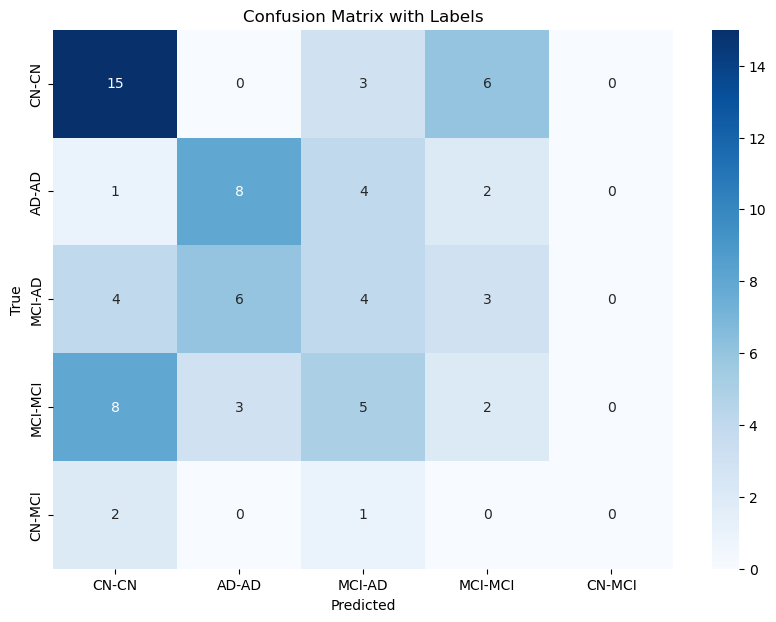

In [20]:
svc_moldel_score = SVC(kernel='rbf', random_state=34)



svc_moldel_score.fit(X_train, y_train)
svc_pred = svc_moldel_score.predict(X_test)
svc_f1_macro = f1_score(y_test, svc_pred, average='macro')
model_f1_macro['SVC'] = svc_f1_macro

print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [21]:


svc_moldel = SVC(kernel='rbf', random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['SVC'] = score_cross



0.3388872291981902


Model                Accuracy
------------------------------
K Neighbors Classifier     0.5065
Random Forest Classifier     0.3896
Gradient Boosting Classifier     0.3766
Extreme Gradient Boosting     0.3766
SCV                      0.3636
Extra Trees Classifier     0.3377


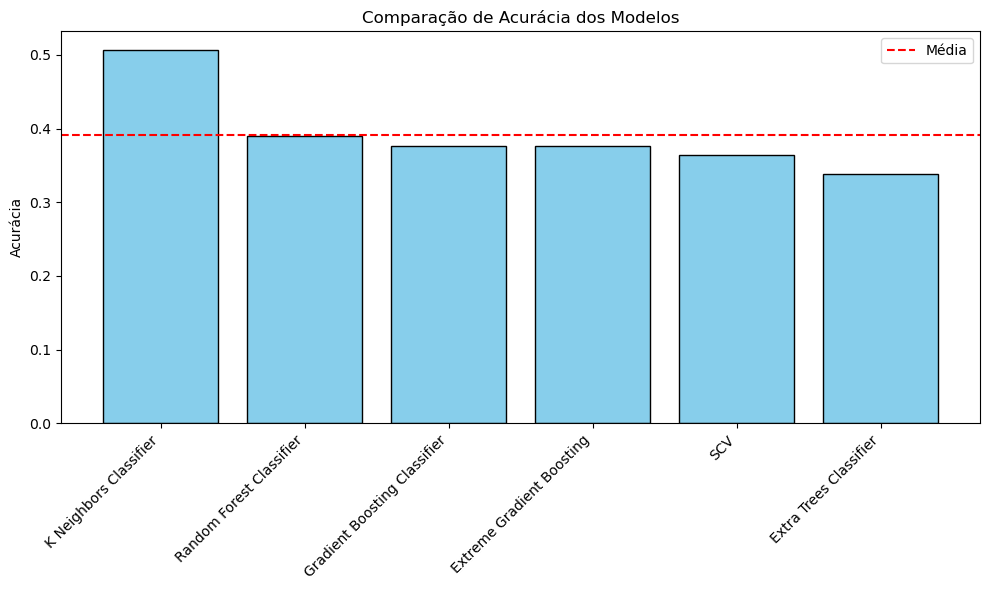

Model                F1-macro
------------------------------
K Neighbors Classifier     0.4054
Gradient Boosting Classifier     0.3022
Random Forest Classifier     0.2904
Extreme Gradient Boosting     0.2840
Extra Trees Classifier     0.2445
SCV                      0.1860


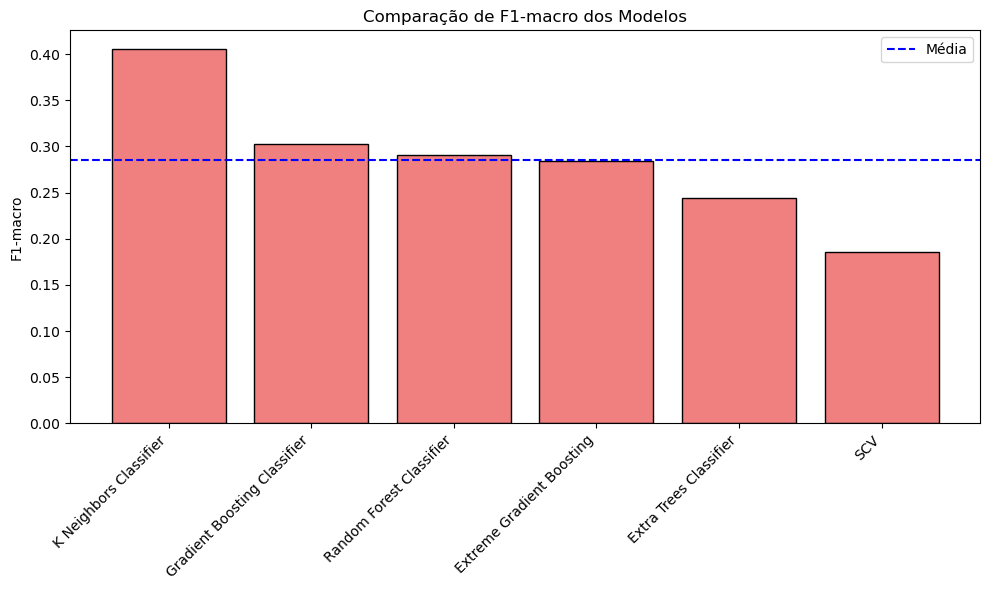

Model                          Cross-Validation Score
---------------------------------------------
Gradient_boosting                  0.3678
XGBoost                            0.3389
SVC                                0.3389
Extra Trees                        0.3388
random_forest                      0.3156
k_night                            0.2939


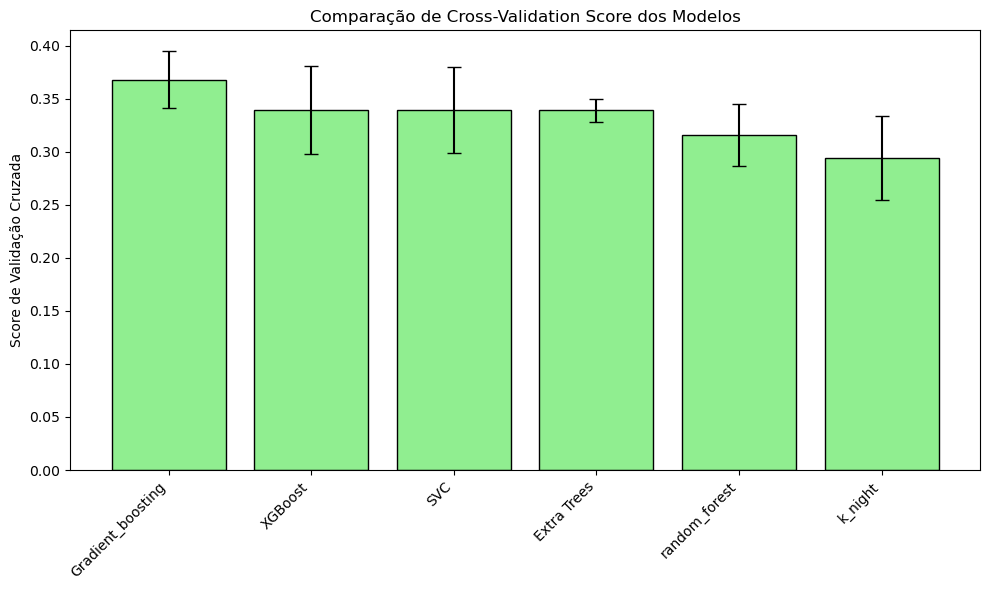

In [22]:


# Função para comparar modelos e criar gráfico com acurácia
def compare_models(Y_test, predictions):
    model_accuracies = {}

    # Calcular acurácia de cada modelo
    for name, prediction in predictions.items():
        accuracy = sum(prediction == Y_test) / len(Y_test)
        model_accuracies[name] = accuracy

    # Ordenar os modelos por acurácia em ordem decrescente
    sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model, accuracy in sorted_models:
        print(model.ljust(20), f"{accuracy:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    accuracies = [accuracy for _, accuracy in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color="skyblue", edgecolor="black")
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', label="Média")
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Função para comparar scores de validação cruzada e criar gráfico
def compare_models_cross_score(model_cross_score):
    # Ordenar modelos por score em ordem decrescente
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))

    # Gerar gráfico de barras com variância
    models = [model for model, _ in sorted_models]
    scores = [score for _, score in sorted_models]

    # Simulação de variância (se você já tiver, substitua pelo real)
    variances = np.random.uniform(0.01, 0.05, len(scores))

    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, yerr=variances, capsize=5, color="lightgreen", edgecolor="black")
    plt.title("Comparação de Cross-Validation Score dos Modelos")
    plt.ylabel("Score de Validação Cruzada")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




def compare_models_f1_macro(Y_test, predictions):
    model_f1_scores = {}

    # Calcular o F1-macro para cada modelo
    for name, prediction in predictions.items():
        f1_macro = f1_score(Y_test, prediction, average='macro')
        model_f1_scores[name] = f1_macro

    # Ordenar os modelos por F1-macro em ordem decrescente
    sorted_models = sorted(model_f1_scores.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "F1-macro")
    print("-" * 30)
    for model, f1_macro in sorted_models:
        print(model.ljust(20), f"{f1_macro:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    f1_scores = [f1_macro for _, f1_macro in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, f1_scores, color="lightcoral", edgecolor="black")
    plt.axhline(y=np.mean(f1_scores), color='blue', linestyle='--', label="Média")
    plt.title("Comparação de F1-macro dos Modelos")
    plt.ylabel("F1-macro")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemplo de uso
predictions = {
    'Random Forest Classifier': rf_pred,
    'Extra Trees Classifier': et_pred,
    'Gradient Boosting Classifier': gb_pred,
    'K Neighbors Classifier': kn_pred,
    'Extreme Gradient Boosting': xgb_pred,
    'SCV':svc_pred
}


compare_models(y_test, predictions)
compare_models_f1_macro(y_test,predictions)
compare_models_cross_score(model_cross_score)

